# Mine all Copernicus Services from copernius.eu

## 2 Steps 

1. Access all ~47 pages with each ~20 results to get the URLs 
2. Access all URLs to access the title and description (possibly also affiliation to the services like land, marine, climate etc.)
3. Chunk texts

# Install transformers, pytorch, haystack. Best in conda Python 3.9 env. Haystack doesn't run on Python 3.11 yet and 3.10 caused problems.
```shell 
conda create -n semantic_search python=3.9
conda activate semantic_search
pip install farm-haystack[all] --user
pip install transformers pytorch --user
```
Use this kernel in VS Code or Jupyter.

## Part 1 query all ~850 services URLs

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time 
from tqdm import tqdm

base_url = "https://www.copernicus.eu/en/accessing-data-where-and-how/copernicus-services-catalogue?page="
start_page = 0
end_page = 49 # can be more than available, makes no difference

# Create an empty list to store data
data_list = []

for page in tqdm(range(start_page, end_page + 1)):
    time.sleep(2)
    url = base_url + str(page)
    response = requests.get(url)

    if response.status_code == 200:
        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find the <div> with the specified classes
        div_with_classes = soup.find("div", class_="col-12 mb-2 media-articles service-catalogue-articles")

        if div_with_classes:
            # Find all <a> elements within the specified <div>
            a_elements = div_with_classes.find_all("a")

            # Extract and append links that start with "/en/access-data/"
            for a in a_elements:
                href = a.get("href")
                if href and href.startswith("/en/access-data/"):
                    full_url = url
                    data_list.append({"Page Number": page, "Page_URL": full_url, "Link": href})
        else:
            print(f"No <div> with specified classes found on page {page}")
    else:
        print(f"Failed to fetch data from page {page}. Status code: {response.status_code}")

# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(data_list)
df["Service_URL"] = "https://www.copernicus.eu" + df["Link"]
del df["Link"]

print("Mining and extraction complete.")
print("Links starting with '/en/access-data/' have been added to the DataFrame.")

In [ ]:
df.to_csv("copernicus_services_october-2023.csv.gz", compression="gzip", encoding="utf-8", index=False) # save intermediate file as backup

## Part 2 Query every individual service page and append title & description

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re  # Import the re module for text processing
from tqdm import tqdm

# Load the initial DataFrame from your CSV file
df = pd.read_csv("copernicus_services_october-2023.csv.gz")#.head(10)
df

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re  # Import the re module for text processing
from tqdm import tqdm

# Load the initial DataFrame from your CSV file
df = pd.read_csv("copernicus_services_october-2023.csv.gz")#.head(10)

# Create empty lists to store extracted data
titles = []
content_text = []
mx_auto_links = []

# Define a function to remove triple quotes from text
def remove_triple_quotes(text):
    return re.sub(r"'''", "", text)

for index, row in tqdm(df.iterrows()):
    url = row["Service_URL"]
    response = requests.get(url)

    if response.status_code == 200:
        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract the main content <div> with the specified class
        main_content_div = soup.find("section")

        if main_content_div:
            # a) Extract h3 element (Title)
            h3_element = main_content_div.find("h3")
            title = h3_element.text if h3_element else "N/A"
            titles.append(title)

            # b) Extract visible text content from div with class "ec-content" and its children
            ec_content_div = main_content_div.find("div", class_="ec-content")
            content = " ".join([remove_triple_quotes(tag.get_text()) for tag in ec_content_div.find_all(True)]) if ec_content_div else "N/A"
            content_text.append(content)

            # c) Extract all href elements in div with class "mx-auto mt-5"
            mx_auto_div = main_content_div.find("div", class_="mx-auto mt-5")
            mx_auto_links_div = mx_auto_div.find_all("a") if mx_auto_div else [""]
            mx_auto_links.append([link.get("href") for link in mx_auto_links_div][0])

            #print(f"Processed page {row['Page Number']} - Title: {title}")
        else:
            print(f"No content <div> found on page {row['Page Number']}")

    else:
        print(f"Failed to fetch data from page {row['Page Number']} {row['Service_URL']} - Status code: {response.status_code}")

# Add the extracted data to the DataFrame
df["Title"] = titles
df["Content"] = content_text
df["Catalogue_URL"] = mx_auto_links

In [ ]:
df.to_csv("copernicus_services_title_descr_url_october-2023.csv.gz", compression="gzip", encoding="utf-8", index=False)

# ---

## Part 3 chunk and index descriptions

Explanation
- Page NUmber & Page URL is from copernicus.eu catalogue 
- Service URL is the dedicated page there 
- Catalogue URL is the "real" URL to the respective service

In [4]:
import pandas as pd
df = pd.read_csv("copernicus_services_title_descr_url_october-2023.csv.gz")
df["Content_Length"] = df.Content.apply(lambda x: len(str(x)))
df = df.sort_values("Content_Length")


<Axes: >

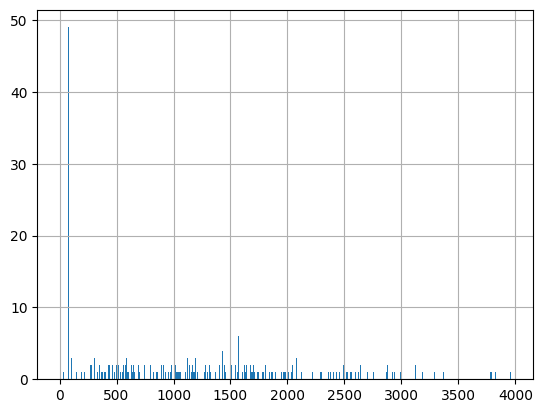

In [5]:
# get an overview of the distribution. luckily the html contains all the information and the js on the website just hides the info, so no cumbersome mining needed

df[df['Content_Length'] < 4000].Content_Length.hist(bins=1000)

In [16]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

tokenizer.tokenize("test this tokenizer")

C:\Users\dome\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['test', 'this', 'token', '##izer']

In [17]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
def token_num(sentence):
    tokens = tokenizer.tokenize(sentence)
    return len(tokens)

token_num("test this tokenizer")

4

In [10]:
from haystack.nodes import PreProcessor # python 3.9.1. works

In [21]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode("test")
embeddings

array([ 1.15734087e-02,  2.51362119e-02, -3.67018729e-02,  5.93248643e-02,
       -7.14901835e-03, -4.11942229e-02,  7.70874098e-02,  3.74424905e-02,
        1.24489954e-02, -6.11765962e-03,  1.70342792e-02, -7.70153478e-02,
       -3.94162664e-04,  2.79090535e-02, -1.59891397e-02, -6.82752132e-02,
        8.88467021e-03, -2.02807020e-02, -8.03598613e-02, -1.30740413e-02,
       -4.10999991e-02, -2.58980934e-02, -2.65386570e-02,  3.30523178e-02,
       -2.20791865e-02,  2.10461020e-02, -5.79219833e-02,  3.29487585e-02,
        2.97074039e-02, -6.22484386e-02,  3.87880392e-02,  3.19906920e-02,
        1.53307682e-02,  4.53069992e-02,  5.31494282e-02,  1.33606149e-02,
        4.12249044e-02,  2.81428769e-02,  1.93984769e-02, -3.25230951e-03,
       -3.61232599e-03, -1.42860264e-01,  3.80712189e-02, -1.09161763e-02,
        2.60939952e-02,  4.13699374e-02, -1.60157550e-02,  5.35600856e-02,
       -5.68594635e-02,  1.22467913e-02, -3.49965878e-02, -3.97541970e-02,
       -4.61430252e-02, -

In [32]:
import torch 

def mean_embedding(in_vectors):
    try:
        return list(torch.mean(torch.tensor(in_vectors),dim=0).numpy())
    except Exception as e:
        print(e)
        return []

mean_embedding([
        [0.17, 0.2, 0.3, 0.4],
    [0.2, 0.3, 0.4, 0.5],
    [0.3, 0.4, 0.5, 0.6]])

[0.22333334, 0.29999998, 0.4, 0.5]

In [13]:
processor = PreProcessor(
    clean_empty_lines=True,
    clean_whitespace=True,
    clean_header_footer=True,
    remove_substrings=None,
    split_by="word",
    split_length=60, # attention: might cut off large table content or similar. Watch out for model max token input!
    split_respect_sentence_boundary=False,
    split_overlap=0,
    max_chars_check=1000000,
    show_progress_bar=False
)

res = processor.process(
    [
    {
        'content': df.iloc[657].Content
    }
]
)

a = [i.to_dict()["content"].strip() for i in res] #res[0].to_dict()
#print(a)
[token_num(i) for i in a]
#mean_embedding([model.encode(i) for i in a])

c:\Users\dome\Anaconda3\envs\scrape\lib\site-packages\pandas\core\dtypes\cast.py:1500: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 104.97docs/s]


[71, 83, 74, 87, 81, 110, 113, 116, 80, 77, 81, 76]

In [14]:
def text_to_embedding(in_text):
    res = processor.process(
        [
            {
                'content': in_text
            }
        ]
    )

    a = [i.to_dict()["content"].strip() for i in res] #res[0].to_dict()

    #print(a)
    #[token_num(i) for i in a] might cut off tables, but anyway not so super important
    return mean_embedding([model.encode(i) for i in a])

In [15]:
df = df.fillna(" ")

In [18]:
df[df.Content == " "]

,Page Number,Service_URL,Page_URL,Title,Content,Catalogue_URL,Content_Length
168,9,https://www.copernicus.eu/en/access-data/coper...,https://www.copernicus.eu/en/accessing-data-wh...,cams-global-atmospheric-composition-forecasts-...,,https://ads.atmosphere.copernicus.eu/cdsapp#!/...,3
169,9,https://www.copernicus.eu/en/access-data/coper...,https://www.copernicus.eu/en/accessing-data-wh...,cams-global-atmospheric-composition-forecasts-...,,https://ads.atmosphere.copernicus.eu/cdsapp#!/...,3
170,9,https://www.copernicus.eu/en/access-data/coper...,https://www.copernicus.eu/en/accessing-data-wh...,cams-global-atmospheric-composition-forecasts-...,,https://ads.atmosphere.copernicus.eu/cdsapp#!/...,3
648,36,https://www.copernicus.eu/en/access-data/coper...,https://www.copernicus.eu/en/accessing-data-wh...,reanalysis-era5-complete-preliminary-back-exte...,,https://cds.climate.copernicus.eu/cdsapp#!/dat...,3
179,9,https://www.copernicus.eu/en/access-data/coper...,https://www.copernicus.eu/en/accessing-data-wh...,cams-global-reanalysis-eac4-external,,https://ads.atmosphere.copernicus.eu/cdsapp#!/...,3
659,36,https://www.copernicus.eu/en/access-data/coper...,https://www.copernicus.eu/en/accessing-data-wh...,reanalysis-era5.1-complete,,https://cds.climate.copernicus.eu/cdsapp#!/dat...,3
180,10,https://www.copernicus.eu/en/access-data/coper...,https://www.copernicus.eu/en/accessing-data-wh...,cams-global-reanalysis-eac4-internal,,https://ads.atmosphere.copernicus.eu/cdsapp#!/...,3


In [25]:
null_vector = [0] * 384
null_vector

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [26]:
df["mean_emebdding"] = df.Content.apply(lambda x: null_vector) # add null vector to all rows by default

In [34]:
df.loc[df.Content != " ", "mean_emebdding"] = df.loc[df.Content != " ", "Content"].progress_apply(lambda x: text_to_embedding(x)) # 13 min!

Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 662.61docs/s]
C:\Users\dome\AppData\Local\Temp\ipykernel_28360\1475821968.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  return list(torch.mean(torch.tensor(in_vectors),dim=0).numpy())
100%|██████████| 827/827 [12:40<00:00,  1.09it/s]


In [63]:
df[['Service_URL','Catalogue_URL','Title', 'Content', 'mean_emebdding']].to_csv("copernicus_services_embeddings.csv.gz", compression="gzip", encoding="utf-8", index=False)

In [65]:
df[['Service_URL','Catalogue_URL','Title', 'Content', 'mean_emebdding']].to_json("copernicus_services_embeddings.json.gz", compression="gzip", orient="records")

# Done 

## Run some semantic search tests here

In [45]:
import torch.nn.functional as F

def cosine_sim(embedding1, embedding2):
    embedding1 = torch.tensor(embedding1, dtype=torch.float32)
    embedding2 = torch.tensor(embedding2, dtype=torch.float32)
    cosine_similarity = float(F.cosine_similarity(embedding1, embedding2, dim=0))
    similarity_score = 0.5 * (cosine_similarity + 1)
    return similarity_score


In [50]:
pd.set_option('display.max_colwidth', 200)

In [58]:
user_query_embedding = model.encode("arctic")
df["similarity_score"] = df.mean_emebdding.apply(lambda x:cosine_sim (user_query_embedding, x) )
df = df.sort_values("similarity_score", ascending=False)
df.head(5).Content

55     Short description:\nArctic Sea and Ice surface temperature  Detailed description:\nArctic Sea and Ice surface temperature product based upon reprocessed AVHRR, (A)ATSR and SLSTR SST observations f...
56     Short description:\nArctic Sea and Ice surface temperature  Detailed description:\nArctic Sea and Ice surface temperature product based upon reprocessed AVHRR, (A)ATSR and SLSTR SST observations f...
589    DEFINITION Net (positive minus negative) volume transport of Atlantic Water through the sections (see Figure 1):  Faroe Shetland Channel (Water mass criteria, T > 5 °C); Barents Sea Opening (T > 3...
707    DEFINITION Net sea-ice volume and area transport through the openings Fram Strait between Spitsbergen and Greenland along 79°N, 20°W - 10°E (positive southward); northern Barents Sea between Svalb...
54     Short description: Arctic Sea and Ice surface temperature product based upon observations from the Metop_A AVHRR instrument. The product is a daily interpolated fiel

In [60]:
pd.set_option('display.max_colwidth', 20)
df


c:\Users\dome\Anaconda3\envs\scrape\lib\site-packages\pandas\core\internals\concat.py:448: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  g = np.find_common_type(upcast_classes, [])
c:\Users\dome\Anaconda3\envs\scrape\lib\site-packages\pandas\core\internals\concat.py:448: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  g = np.find_common_type(upcast_classes, [])


,Page Number,Service_URL,Page_URL,Title,Content,Catalogue_URL,Content_Length,mean_emebdding,similarity_score
55,3,https://www.cope...,https://www.cope...,Arctic Ocean - S...,Short descriptio...,http://marine.co...,514,"[-0.10770285, 0....",0.775680
56,3,https://www.cope...,https://www.cope...,Arctic Ocean - S...,Short descriptio...,http://marine.co...,514,"[-0.10976737, 3....",0.774151
589,32,https://www.cope...,https://www.cope...,Nordic Seas Volu...,DEFINITION Net (...,http://marine.co...,3121,"[-0.012092872, 0...",0.768544
707,39,https://www.cope...,https://www.cope...,Sea Ice Area/Vol...,DEFINITION Net s...,http://marine.co...,2541,"[0.0069741383, -...",0.761864
54,3,https://www.cope...,https://www.cope...,Arctic Ocean - S...,Short descriptio...,http://marine.co...,369,"[-0.11811, 0.048...",0.745096
...,...,...,...,...,...,...,...,...,...
406,22,https://www.cope...,https://www.cope...,Gross Dry Matter...,Gross dry matter...,https://land.cop...,600,"[-0.037759975, -...",0.498455
819,45,https://www.cope...,https://www.cope...,viewer-sis-fishe...,Viewer applicati...,https://cds.clim...,277,"[0.06399927, -0....",0.497978
818,45,https://www.cope...,https://www.cope...,viewer-satellite...,Viewer applicati...,https://cds.clim...,277,"[0.06399927, -0....",0.497978
816,45,https://www.cope...,https://www.cope...,viewer-satellite...,Viewer applicati...,https://cds.clim...,277,"[0.06399927, -0....",0.497978


## Could also add the services like land, marine etc. from the URL
... but it's slightly messy, so it might be better to re-run the mining and get the service from each individual site

In [26]:
df = pd.read_json("copernicus_services_embeddings.json.gz")
df

,Service_URL,Catalogue_URL,Title,Content,mean_emebdding
0,https://www.copernicus.eu/en/access-data/coper...,http://marine.copernicus.eu/services-portfolio...,Arctic Ocean - Sea and Ice Surface Temperature...,Short description:\nArctic Sea and Ice surface...,"[-0.1077028513, 0.0030943127, 0.00185287050000..."
1,https://www.copernicus.eu/en/access-data/coper...,http://marine.copernicus.eu/services-portfolio...,Arctic Ocean - Sea and Ice Surface Temperature...,Short description:\nArctic Sea and Ice surface...,"[-0.10976736990000001, 3.9076400000000004e-05,..."
2,https://www.copernicus.eu/en/access-data/coper...,http://marine.copernicus.eu/services-portfolio...,Nordic Seas Volume Transports from Reanalysis,DEFINITION Net (positive minus negative) volum...,"[-0.012092871600000001, 0.0160790421, 0.024800..."
3,https://www.copernicus.eu/en/access-data/coper...,http://marine.copernicus.eu/services-portfolio...,Sea Ice Area/Volume Transport in the Nordic Se...,DEFINITION Net sea-ice volume and area transpo...,"[0.0069741383, -0.0072253393, 0.04711299760000..."
4,https://www.copernicus.eu/en/access-data/coper...,http://marine.copernicus.eu/services-portfolio...,Arctic Ocean - Sea and Ice Surface Temperature,Short description: Arctic Sea and Ice surface ...,"[-0.1181100011, 0.0483529195, 0.0007129876, 0...."
...,...,...,...,...,...
829,https://www.copernicus.eu/en/access-data/coper...,https://land.copernicus.eu/global/products/dmp,Gross Dry Matter Productivity 2014-present (ra...,Gross dry matter Productivity (GDMP) is an ind...,"[-0.0377599746, -0.0487331115, 0.0180470608, 0..."
830,https://www.copernicus.eu/en/access-data/coper...,https://cds.climate.copernicus.eu/cdsapp#!/dat...,viewer-sis-fisheries-abundance,Viewer application for dataset More details ab...,"[0.0639992729, -0.0517726317, -0.1022773683, 0..."
831,https://www.copernicus.eu/en/access-data/coper...,https://cds.climate.copernicus.eu/cdsapp#!/dat...,viewer-satellite-surface-radiation-budget,Viewer application for dataset More details ab...,"[0.0639992729, -0.0517726317, -0.1022773683, 0..."
832,https://www.copernicus.eu/en/access-data/coper...,https://cds.climate.copernicus.eu/cdsapp#!/dat...,viewer-satellite-lake-water-level,Viewer application for dataset More details ab...,"[0.0639992729, -0.0517726317, -0.1022773683, 0..."


In [25]:
import pandas as pd
df = pd.read_json("copernicus_services_embeddings.json.gz")

df = df[df["Catalogue_URL"].str.contains("://")]
df["cata"] = df["Catalogue_URL"].apply(lambda x: x.split("://")[1].split(".copernicus.eu")[0])
df["cata"].unique()

array(['marine', 'cds.climate', 'land', 'cryo.land', 'www.wekeo.eu',
       'egms.land', 'ads.atmosphere',
       'www.wekeo.eu/data?view=viewer&t=1566840390697&z=0&center=13.08408%2C48.33915&zoom=12.34&layers=W3siaWQiOiJjNCIsImxheWVySWQiOiJFTzpIUlZQUDpEQVQ6VkVHRVRBVElPTi1JTkRJQ0VTL19fREVGQVVMVF9fL0NMTVNfSFJWUFBfVklfUFBJXzEwTSIsInpJbmRleCI6MTEwLCJpc0hpZGRlbiI6dHJ1ZX0seyJpZCI6ImM1IiwibGF5ZXJJZCI6IkVPOkhSVlBQOkRBVDpWRUdFVEFUSU9OLUlORElDRVMvX19ERUZBVUxUX18vQ0xNU19IUlZQUF9WSV9RRkxBRzJfMTBNIiwiekluZGV4IjoxMjB9XQ%3D%3D',
       'www.wekeo.eu/data?view=viewer&t=1566840390697&z=0&center=13.08408%2C48.33915&zoom=12.34&layers=W3siaWQiOiJjMCIsImxheWVySWQiOiJFTzpIUlZQUDpEQVQ6VkVHRVRBVElPTi1JTkRJQ0VTL19fREVGQVVMVF9fL0NMTVNfSFJWUFBfVklfTEFJXzEwTSIsInpJbmRleCI6NjB9LHsiaWQiOiJjMSIsImxheWVySWQiOiJFTzpIUlZQUDpEQVQ6VkVHRVRBVElPTi1JTkRJQ0VTL19fREVGQVVMVF9fL0NMTVNfSFJWUFBfVklfUUZMQUcyXzEwTSIsInpJbmRleCI6ODAsImlzSGlkZGVuIjp0cnVlfV0%3D&initial=1',
       'www.wekeo.eu/data?view=viewer&t=1566840390697&z=0&cen